In [ ]:
"""
Ant Colony Optimization for Route Planning with Urgency and Weight Penalty
---------------------------------------------------------------------------
Author: YI LUO
Date: 2025-04-10

This notebook applies Ant Colony Optimization (ACO) to a simplified version of the Vehicle Routing Problem (VRP),
based on a dataset from:
    https://www.kaggle.com/datasets/mexwell/large-scale-route-optimization/data

The core ACO algorithm includes:
- Distance-based pathfinding using pheromone and heuristic influences
- Soft prioritization of deliveries using urgency and weight penalties
    (higher urgency and lower weight make a node more attractive)

What This Model Does:
---------------------
- Uses ACO to find short delivery tours starting and ending at a depot
- Adds a penalty term to deprioritize heavy or low-urgency deliveries
- Updates pheromones based on the shortest path found per iteration

 the model serves as a foundation for more advanced ACO applications in real-world logistics.
To make it fully constraint-aware, future work could extend the algorithm with:
- Real-time ETA simulation
- Weight tracking
- Constraint rejection or route splitting
- Support for multiple vehicles or trips
"""

In [1]:
# SECTION 1: Imports and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set global plot styles
sns.set(style="whitegrid")

# Load datasets
distance_df = pd.read_csv('/Users/luoyi/Desktop/10_kaggle/11_Route_Optimization/distance.csv')
orders_df = pd.read_csv('/Users/luoyi/Desktop/10_kaggle/11_Route_Optimization/order_large.csv')

Distance dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3782 entries, 0 to 3781
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Source       3782 non-null   object
 1   Destination  3782 non-null   object
 2   Distance(M)  3782 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 88.8+ KB
None

Orders dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4635 entries, 0 to 4634
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Order_ID        4635 non-null   object
 1   Material_ID     4635 non-null   object
 2   Item_ID         4635 non-null   object
 3   Source          4635 non-null   object
 4   Destination     4635 non-null   object
 5   Available_Time  4635 non-null   object
 6   Deadline        4635 non-null   object
 7   Danger_Type     4635 non-null   object
 8   Area            4635 non-null   int6

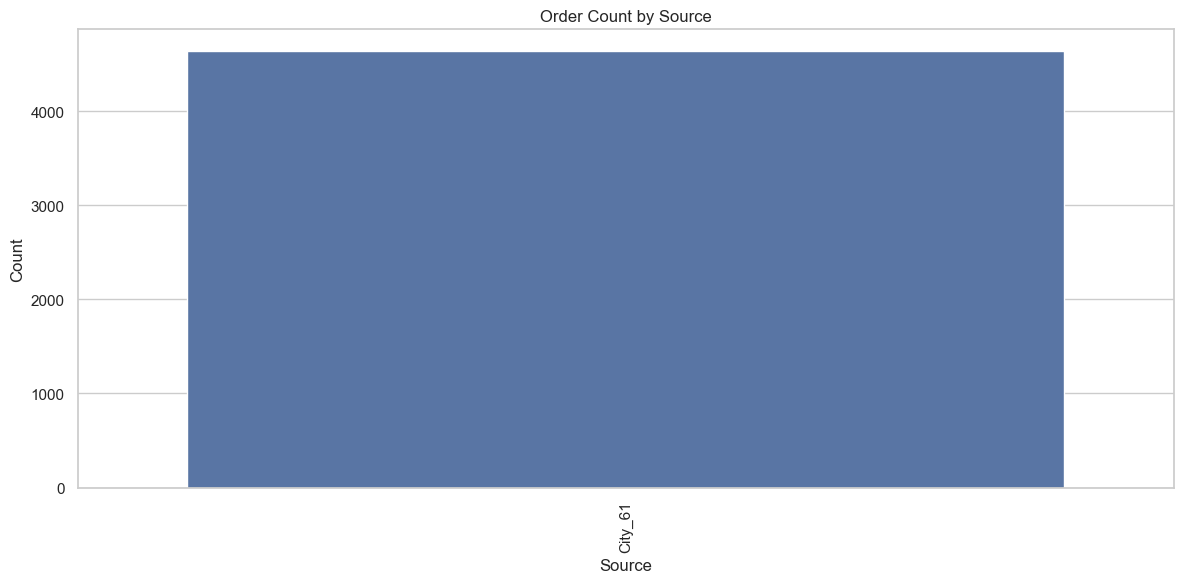

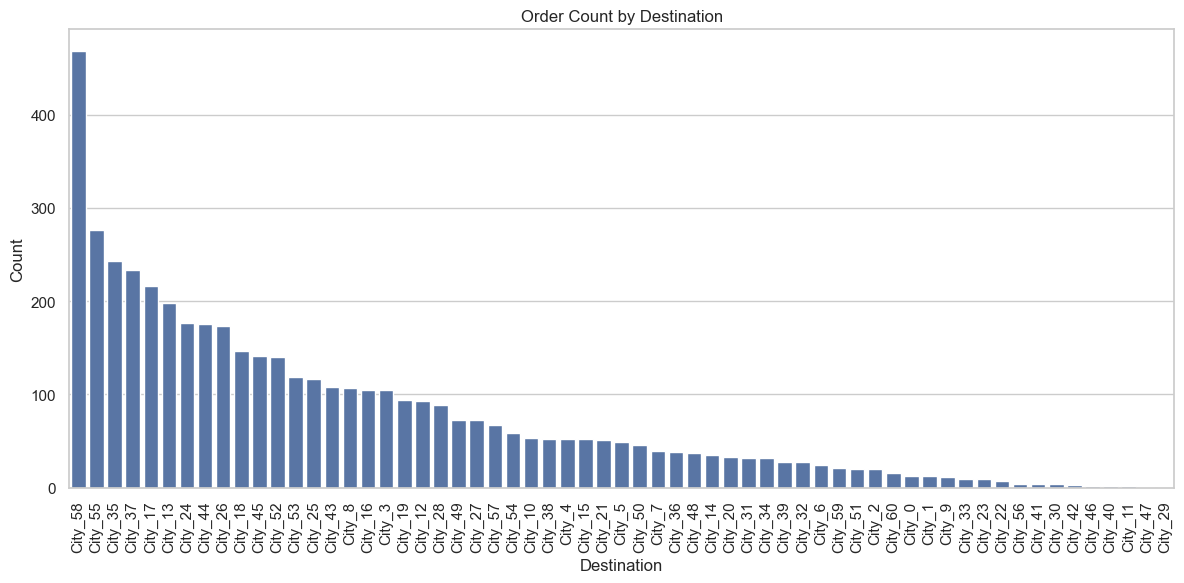

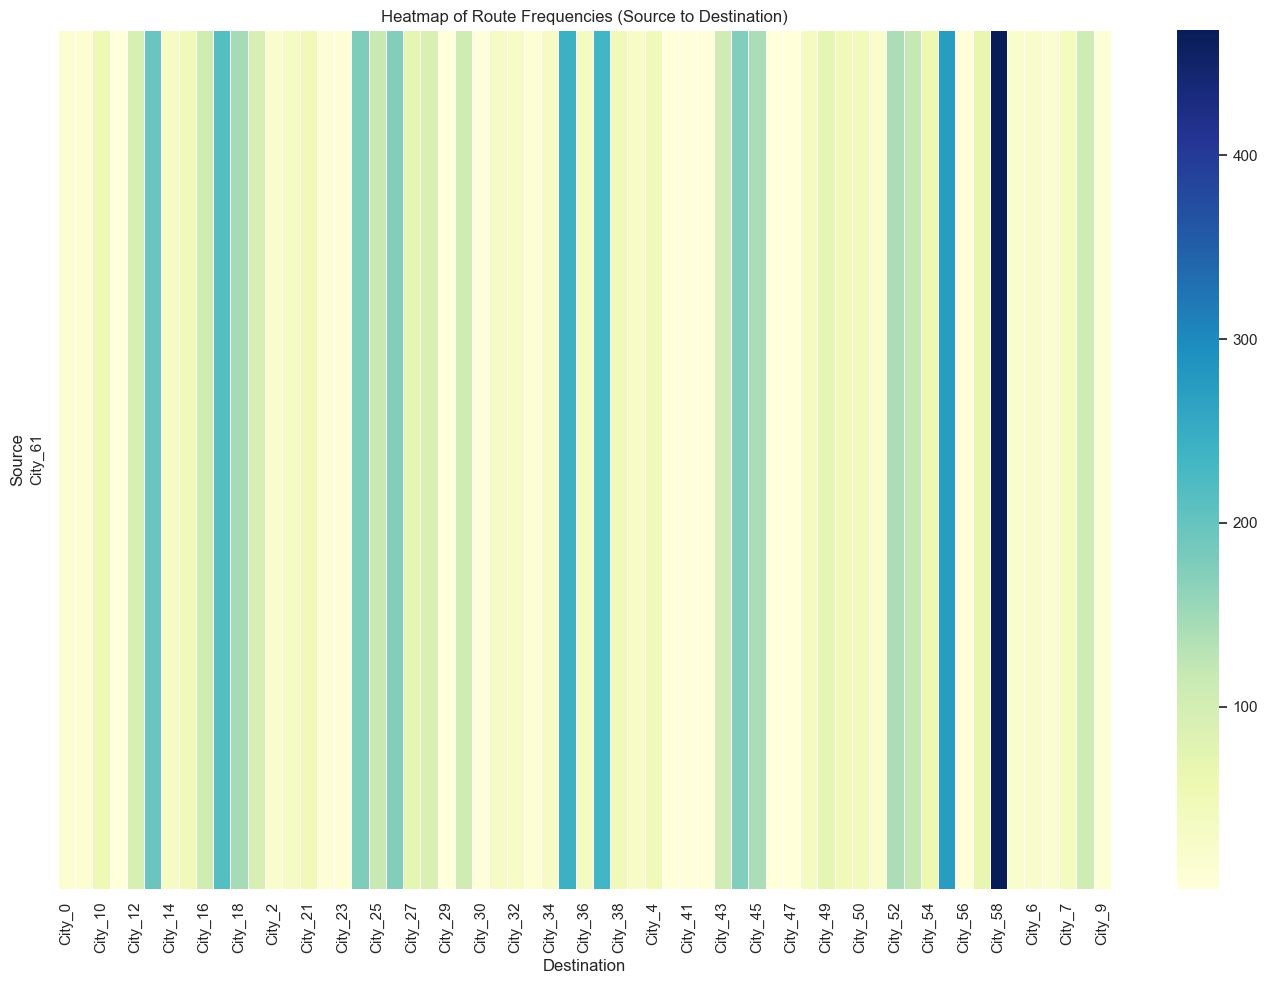

In [2]:
# SECTION 2: Exploratory Data Analysis (EDA)

# Display basic information about the datasets
print("Distance dataset info:")
print(distance_df.info())
print("\nOrders dataset info:")
print(orders_df.info())

# Check for null values in both datasets
print("\nMissing values in distance dataset:", distance_df.isnull().sum().sum())
print("Missing values in orders dataset:", orders_df.isnull().sum().sum())

# Display summary statistics for numerical fields
print("\nDistance dataset summary:")
print(distance_df.describe())
print("\nOrders dataset summary:")
print(orders_df.describe())

# Visualize order distribution by Source location
plt.figure(figsize=(12, 6))
sns.countplot(x='Source', data=orders_df, order=orders_df['Source'].value_counts().index)
plt.title('Order Count by Source')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Visualize order distribution by Destination location
plt.figure(figsize=(12, 6))
sns.countplot(x='Destination', data=orders_df, order=orders_df['Destination'].value_counts().index)
plt.title('Order Count by Destination')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Visualize Source-Destination pair frequency using heatmap
route_counts = orders_df.groupby(['Source', 'Destination']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 10))
sns.heatmap(route_counts, annot=False, cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap of Route Frequencies (Source to Destination)')
plt.xlabel('Destination')
plt.ylabel('Source')
plt.tight_layout()
plt.show()


In [5]:
class VRPDataLoader:
    """
    Load delivery order and distance data for VRP optimization.
    Builds a city-to-city distance matrix and indexing system.
    """
    def __init__(self, distance_file, order_file):
        self.distance_df = pd.read_csv(distance_file)
        self.order_df = pd.read_csv(order_file)
        self.cities = self._extract_cities()
        self.city_to_index = {city: i for i, city in enumerate(self.cities)}
        self.index_to_city = {i: city for city, i in self.city_to_index.items()}
        self.distance_matrix = self._build_distance_matrix()

    def _extract_cities(self):
        cities = pd.unique(self.order_df[['Source', 'Destination']].values.ravel('K'))
        return sorted(cities)

    def _build_distance_matrix(self):
        n = len(self.cities)
        matrix = np.full((n, n), np.inf)

        for _, row in self.distance_df.iterrows():
            src, dst, dist = row['Source'], row['Destination'], row['Distance(M)']
            if src in self.city_to_index and dst in self.city_to_index:
                i, j = self.city_to_index[src], self.city_to_index[dst]
                matrix[i][j] = dist
                matrix[j][i] = dist  # assume symmetric

        np.fill_diagonal(matrix, 1e6)  # avoid self-routes
        return matrix

    def preview(self):
        print("📍 Number of cities:", len(self.cities))
        print("📏 Distance matrix shape:", self.distance_matrix.shape)
        df = pd.DataFrame(self.distance_matrix, index=self.cities, columns=self.cities)
        print("🔍 Matrix preview:\n", df.iloc[:5, :5].round(0))

In [6]:
loader = VRPDataLoader(
    distance_file="/Users/luoyi/Desktop/10_kaggle/11_Route_Optimization/distance.csv",
    order_file="/Users/luoyi/Desktop/10_kaggle/11_Route_Optimization/order_large.csv"
)
loader.preview()

📍 Number of cities: 62
📏 Distance matrix shape: (62, 62)
🔍 Matrix preview:
             City_0     City_1    City_10    City_11    City_12
City_0   1000000.0    50615.0   721273.0   685050.0   922795.0
City_1     50615.0  1000000.0   700550.0   664327.0   902072.0
City_10   721273.0   700550.0  1000000.0   270054.0   263154.0
City_11   685050.0   664327.0   270054.0  1000000.0   362376.0
City_12   922795.0   902072.0   263154.0   362376.0  1000000.0


In [7]:
def build_city_metadata(order_df, city_to_index):
    """
    Build urgency and weight metadata for each city in the routing problem.

    Parameters:
        order_df: full order data with time and weight columns
        city_to_index: dict mapping city names to index

    Returns:
        metadata_df: DataFrame indexed by city index with 'Urgency' and 'Weight'
    """
    # Convert time columns to datetime
    order_df['Available_Time'] = pd.to_datetime(order_df['Available_Time'])
    order_df['Deadline'] = pd.to_datetime(order_df['Deadline'])

    # Compute urgency in hours
    order_df['Urgency'] = (order_df['Deadline'] - order_df['Available_Time']).dt.total_seconds() / 3600

    # Aggregate: take most urgent deadline and total weight per destination
    summary = order_df.groupby("Destination").agg({
        "Urgency": "min",
        "Weight": "sum"
    }).reset_index()

    # Map city name to matrix index
    summary["City_Index"] = summary["Destination"].map(city_to_index)
    summary.dropna(subset=["City_Index"], inplace=True)
    summary.set_index("City_Index", inplace=True)

    return summary[["Urgency", "Weight"]]

In [8]:
metadata = build_city_metadata(loader.order_df, loader.city_to_index)
metadata.head()

,Urgency,Weight
City_Index,,
0,36.0,362400000
1,36.0,352800000
2,60.0,527230000
3,96.0,8520000
4,60.0,1331320000


In [9]:
class AntColonyOptimizer:
    def __init__(self, distance_matrix, metadata=None, num_ants=30, num_iterations=200, alpha=1.0, beta=2.0, rho=0.5):
        self.distances = distance_matrix
        self.pheromones = np.ones_like(distance_matrix)
        self.metadata = metadata
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha  # pheromone influence
        self.beta = beta    # heuristic influence
        self.rho = rho      # evaporation rate
        self.num_cities = distance_matrix.shape[0]
        self.depot = 0      # assume starting city is index 0

    def _get_penalty(self, city_idx):
        if self.metadata is None or city_idx not in self.metadata.index:
            return 1.0  # no priority
        urgency = self.metadata.loc[city_idx, 'Urgency']
        weight = self.metadata.loc[city_idx, 'Weight']
        # Higher urgency and weight → more attractive → lower penalty (inverted)
        penalty = (1.0 / (urgency + 1e-3)) + (weight / 1e7)
        return penalty

    def _calculate_probabilities(self, current_city, visited):
        allowed = [i for i in range(self.num_cities) if i not in visited and i != self.depot]
        probs = np.zeros(self.num_cities)

        for j in allowed:
            tau = self.pheromones[current_city][j] ** self.alpha
            eta = (1.0 / self.distances[current_city][j]) ** self.beta
            penalty = self._get_penalty(j)
            probs[j] = tau * eta * penalty

        total = np.sum(probs)
        return probs / total if total > 0 else np.ones(self.num_cities) / self.num_cities

    def _construct_solution(self):
        route = [self.depot]
        visited = set(route)
        total_distance = 0
        current = self.depot

        while len(visited) < self.num_cities:
            probs = self._calculate_probabilities(current, visited)
            next_city = np.random.choice(range(self.num_cities), p=probs)

            if next_city in visited:
                continue

            visited.add(next_city)
            route.append(next_city)
            total_distance += self.distances[current][next_city]
            current = next_city

        total_distance += self.distances[current][self.depot]
        route.append(self.depot)

        return route, total_distance

    def run(self):
        best_route = None
        best_distance = float('inf')

        for _ in range(self.num_iterations):
            routes = []
            distances = []

            for _ in range(self.num_ants):
                route, dist = self._construct_solution()
                routes.append(route)
                distances.append(dist)

            min_idx = np.argmin(distances)
            if distances[min_idx] < best_distance:
                best_distance = distances[min_idx]
                best_route = routes[min_idx]

            # Evaporate pheromones
            self.pheromones *= (1 - self.rho)

            # Reinforce best path
            for i in range(len(best_route) - 1):
                a, b = best_route[i], best_route[i + 1]
                self.pheromones[a][b] += 1.0 / best_distance

        return best_route, best_distance

In [10]:
# Step 1: Run ACO
aco = AntColonyOptimizer(
    distance_matrix=loader.distance_matrix,
    metadata=metadata,
    num_ants=62,             # match city count for thorough search
    num_iterations=300,      # increase for better convergence
    alpha=1,
    beta=2,
    rho=0.5
)

best_indices, best_distance = aco.run()

# Step 2: Convert indices to city names
best_route = [loader.index_to_city[i] for i in best_indices]

# Step 3: Print results
print("📍 Optimized Route:")
print(" ➡ ".join(best_route))
print(f"\n📏 Total Distance: {best_distance:,.0f} meters")

📍 Optimized Route:
City_0 ➡ City_37 ➡ City_38 ➡ City_1 ➡ City_28 ➡ City_27 ➡ City_25 ➡ City_8 ➡ City_23 ➡ City_22 ➡ City_29 ➡ City_9 ➡ City_11 ➡ City_35 ➡ City_34 ➡ City_13 ➡ City_14 ➡ City_54 ➡ City_53 ➡ City_5 ➡ City_55 ➡ City_12 ➡ City_44 ➡ City_43 ➡ City_41 ➡ City_40 ➡ City_58 ➡ City_56 ➡ City_57 ➡ City_7 ➡ City_52 ➡ City_48 ➡ City_45 ➡ City_46 ➡ City_42 ➡ City_4 ➡ City_59 ➡ City_3 ➡ City_60 ➡ City_6 ➡ City_36 ➡ City_50 ➡ City_49 ➡ City_61 ➡ City_51 ➡ City_18 ➡ City_17 ➡ City_16 ➡ City_15 ➡ City_19 ➡ City_20 ➡ City_21 ➡ City_47 ➡ City_32 ➡ City_33 ➡ City_39 ➡ City_2 ➡ City_26 ➡ City_10 ➡ City_30 ➡ City_24 ➡ City_31 ➡ City_0

📏 Total Distance: 23,180,652 meters


/var/folders/4n/mv7_dxg12q5f54_fvy52lqlw0000gn/T/ipykernel_41537/2258961822.py:42: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/luoyi/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


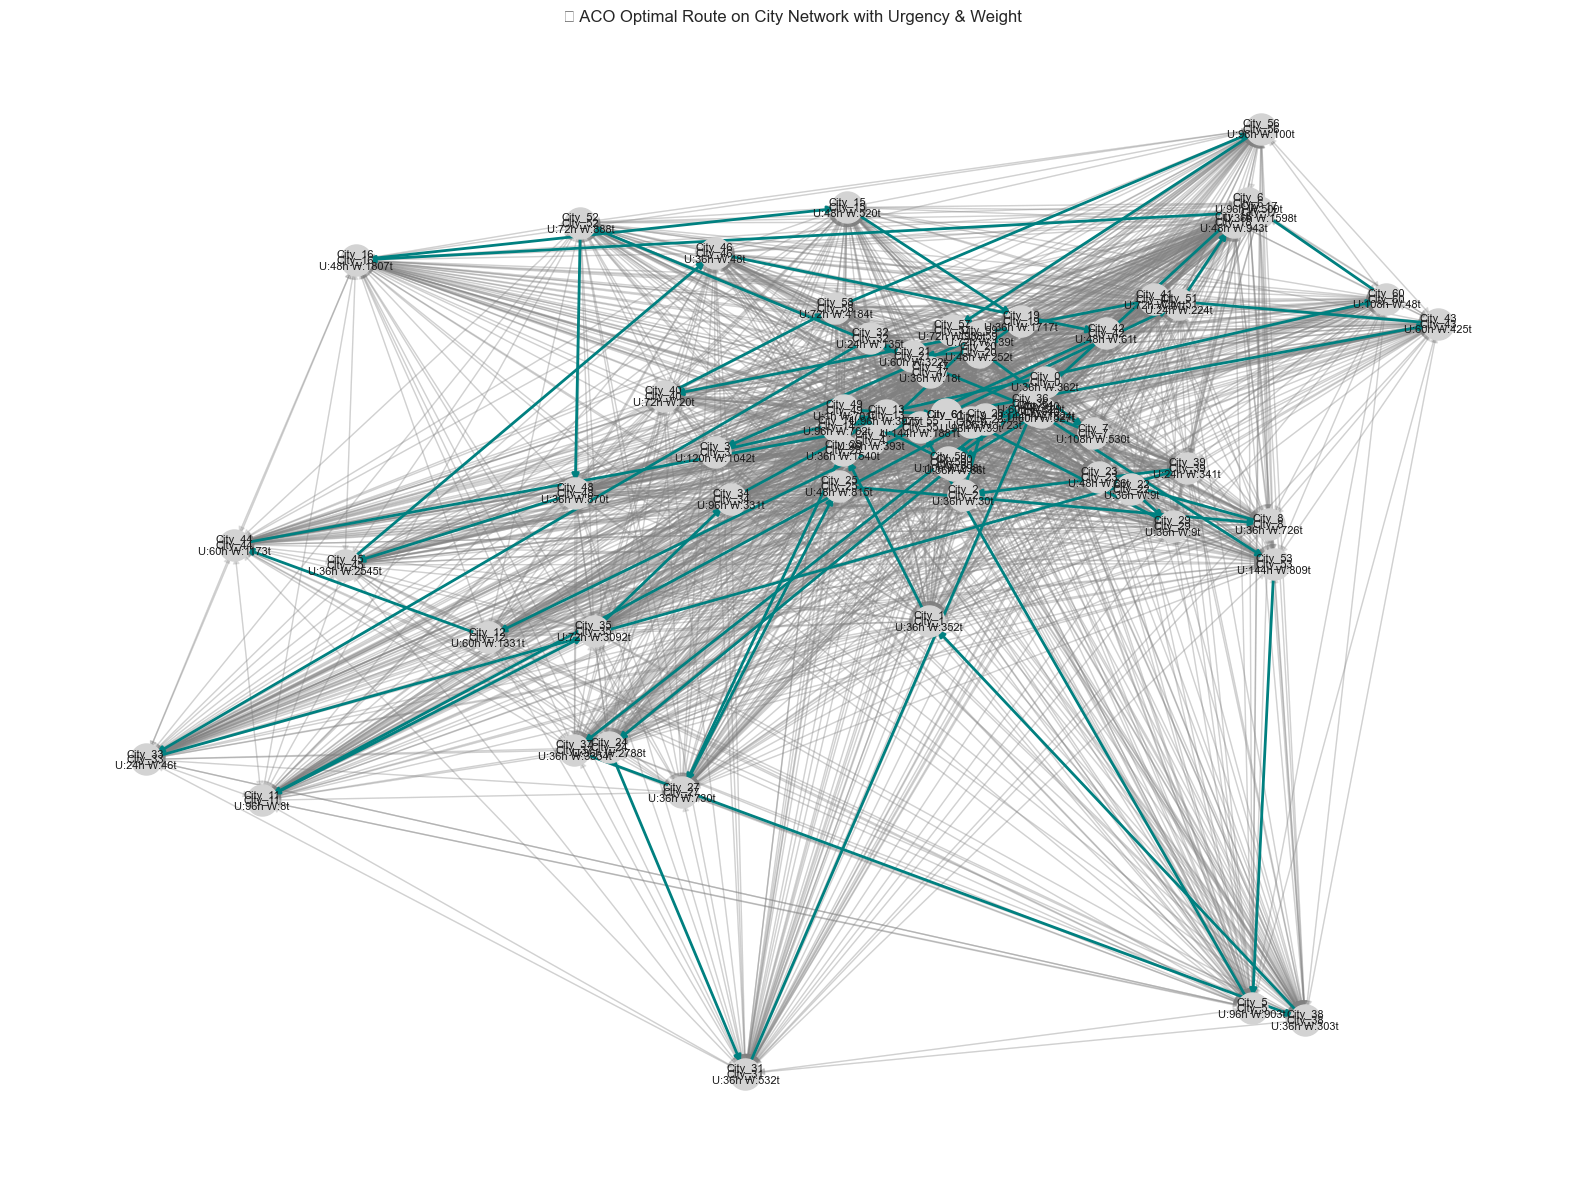

In [11]:
import networkx as nx

def draw_route_network(cities, distance_matrix, best_route, city_to_index, metadata=None):
    G = nx.DiGraph()
    G.add_nodes_from(cities)

    # Add all possible edges
    for i in range(len(cities)):
        for j in range(len(cities)):
            if i != j and distance_matrix[i][j] < np.inf:
                G.add_edge(cities[i], cities[j], weight=distance_matrix[i][j])

    # Highlight the optimal route
    route_edges = list(zip(best_route[:-1], best_route[1:]))

    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, seed=42)

    # Draw base graph
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray')
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.2)
    nx.draw_networkx_labels(G, pos, font_size=8)

    # Draw optimal route path
    nx.draw_networkx_edges(G, pos, edgelist=route_edges, edge_color='teal', width=2)

    # Optional: add urgency/weight labels
    if metadata is not None:
        labels = {}
        for node in G.nodes:
            idx = city_to_index.get(node)
            if idx in metadata.index:
                urgency = metadata.loc[idx, 'Urgency']
                weight = metadata.loc[idx, 'Weight']
                labels[node] = f"{node}\nU:{int(urgency)}h W:{int(weight/1e6)}t"
            else:
                labels[node] = node
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    plt.title("📍 ACO Optimal Route on City Network with Urgency & Weight")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Draw the graph
draw_route_network(
    cities=loader.cities,
    distance_matrix=loader.distance_matrix,
    best_route=best_route,
    city_to_index=loader.city_to_index,
    metadata=metadata
)